# **Projeto Integrado - Applied Statistics**

A QuantumFinance está acompanhando um crescimento de inadimplência entre seus clientes e solicita a consultoria para desenvolver uma análise com base na sua carteira atual de clientes.Para que a QuantumFinance tome decisões mais precisas sobre concessões de crédito, ela precisa aprimorar seu modelo de crédito.

**Desafio**: Com o objeto de trazer novos clientes com o perfil de baixo risco de crédito desenvolva um modelo de Credit Scoring. Desenvolver o modelo preditivo mediante uso do valor target disponível na base de dados
“Base_ScoreCredito_QuantumFinance.csv” e criar um simulador do modelo para os analistas de créditos e gerentes
de conta.

## **Carregando o dataset**

In [ ]:
# importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # ferramentas estatísticas (distribuições probabilísticas, funções estatísticas e testes estatísticos)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Configurar o estilo e as cores dos gráficos
plt.style.use('ggplot') # esquema de cores e layout que deixa os gráficos visualmente melhores (informativo e agradável)
cores_calor = sns.color_palette(['#FF4500', '#FF6347', '#FFD700', '#FFA500', '#FF1493', '#FF69B4', '#FF8C00'])
sns.set_palette(cores_calor) # paleta de cor

## **Exploração e limpeza de dados**

In [ ]:
scorecred = pd.read_csv('/content/Base_ScoreCredito_QuantumFinance.csv', delimiter=';', encoding='utf-8')
scorecred.head(4)

,id,idade,sexo,estado_civil,escola,Qte_dependentes,tempo_ultimoservico,trabalha,vl_salario_mil,reg_moradia,casa_propria,vl_imovel_em_mil,Qte_cartoes,Qte_carros,SCORE_CREDITO
0,708082083,45,F,casado,graduacao,3,40,1,"40,089665024322",3,0,0,1,1,778
1,708083283,58,M,solteiro,ensino fundam,0,44,1,"66,557645274838",3,0,0,1,0,"276,3"
2,708084558,46,M,divorciado,doutorado,3,35,1,"123,68182089138",6,0,0,1,1,401
3,708085458,34,F,solteiro,mestrado,0,22,1,"19,7159343168329",6,0,0,1,0,"347,4"


In [ ]:
print(scorecred.columns)

Index(['id', 'idade', 'sexo', 'estado_civil', 'escola', 'Qte_dependentes',
       'tempo_ultimoservico', 'trabalha', 'vl_salario_mil', 'reg_moradia',
       'casa_propria', 'vl_imovel_em_mil', 'Qte_cartoes', 'Qte_carros',
       'SCORE_CREDITO'],
      dtype='object')


In [ ]:
scorecred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   10127 non-null  int64 
 1   idade                10127 non-null  int64 
 2   sexo                 10127 non-null  object
 3   estado_civil         10127 non-null  object
 4   escola               10127 non-null  object
 5   Qte_dependentes      10127 non-null  int64 
 6   tempo_ultimoservico  10127 non-null  int64 
 7   trabalha             10127 non-null  int64 
 8   vl_salario_mil       10127 non-null  object
 9   reg_moradia          10127 non-null  int64 
 10  casa_propria         10127 non-null  int64 
 11  vl_imovel_em_mil     10127 non-null  int64 
 12  Qte_cartoes          10127 non-null  int64 
 13  Qte_carros           10127 non-null  int64 
 14  SCORE_CREDITO        10127 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.2+ MB


In [ ]:
# converter de string para float, removendo a vírgula
scorecred['vl_salario_mil'] = scorecred['vl_salario_mil'].str.replace(',', '.').astype(float)
scorecred['SCORE_CREDITO'] = scorecred['SCORE_CREDITO'].str.replace(',', '.').astype(float)

In [ ]:
print(scorecred.describe())

                 id         idade  Qte_dependentes  tempo_ultimoservico  \
count  1.012700e+04  10127.000000     10127.000000         10127.000000   
mean   7.391776e+08     46.325960         1.547447            34.133208   
std    3.690378e+07      8.016814         1.489079             8.221428   
min    7.080821e+08     26.000000         0.000000             7.000000   
25%    7.130368e+08     41.000000         0.000000            30.000000   
50%    7.179264e+08     46.000000         1.000000            34.000000   
75%    7.731435e+08     52.000000         3.000000            39.000000   
max    8.283431e+08     73.000000         5.000000            57.000000   

           trabalha  vl_salario_mil   reg_moradia  casa_propria  \
count  10127.000000    10127.000000  10127.000000  10127.000000   
mean       0.911919       70.209002      3.783450      0.352424   
std        0.283427       55.567032      1.580486      0.477749   
min        0.000000        0.000000      1.000000      0

## Insights

### 1. Idade
- **Média**: 46,33 anos
- **STD**: 8,02 anos
- **Faixa etária**: 26 a 73 anos

### 2. Qtd de dependentes
- **Média**: 1,55 - pelo menos 1 dependente, então?
- **25% a 75%:** 25% deles não têm dependentes, mas **75%** têm pelo menos um.
- **Máximo**: O número máximo de dependentes é 5

### 3. Tempo no último serviço
- **Média**: 34,13 meses (2,8 anos)
- **Desvio padrão**: 8,22 meses
- **Veriação**: 7 a 57 meses, mas a maioria está entre 30 e 39 meses.

### 4. Trabalho
- **Média**: 0.91 (91%) - indicando que a grande maioria trabalha

### 5. Casa própria
- **Casa Própria**: 35% têm casa própria

### 6. Valor do imóvel
- **Média**: 208.999 mil
- **Std**: 378.495 mil, desvio muito alto
- **Faixa de Valores**:0 a 1.800 mil - o que são esses 0?

### 7. Quantidade de cartões
- **Média**: 1,08 cartões, o que indica que cada um tem em média pelo menos 1 cartão?

### 8. Quantidade de carros
- **Média**: 0,62 carros por cliente - muitos não têm

### 9. Região de moradia
- **Média**: 3,78 - a maioria mora em regiões de "nível médio"


In [ ]:
# qtd de nulos
print(scorecred.isnull().sum())

id                     0
idade                  0
sexo                   0
estado_civil           0
escola                 0
Qte_dependentes        0
tempo_ultimoservico    0
trabalha               0
vl_salario_mil         0
reg_moradia            0
casa_propria           0
vl_imovel_em_mil       0
Qte_cartoes            0
Qte_carros             0
SCORE_CREDITO          0
dtype: int64


SEM NULOS

________________________________

Entendendo a variável Score_Credito

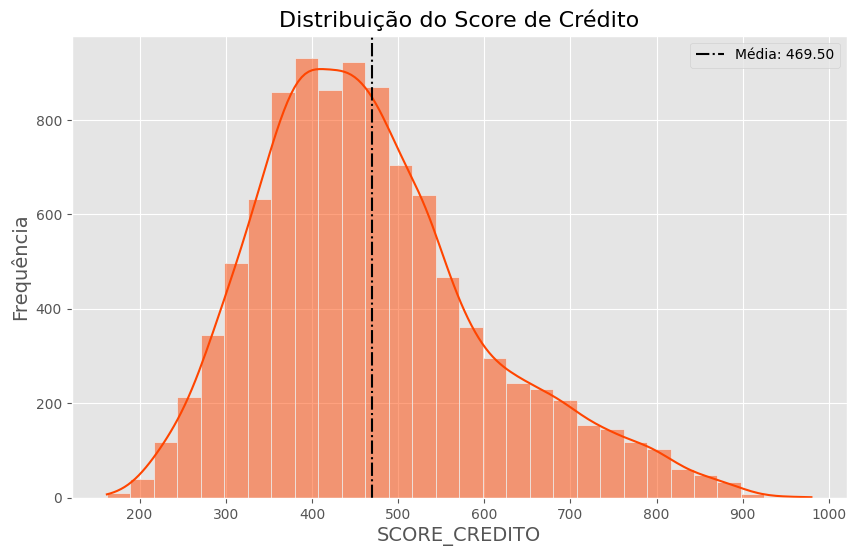

In [ ]:
# criar a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 6))

# gerar o histograma com KDE
sns.histplot(scorecred['SCORE_CREDITO'], bins=30, kde=True, ax=ax) # uso do kde para add uma linha de estimativa de densidade de kernel ao hist.

# add título e rótulos aos eixos
ax.set_title('Distribuição do Score de Crédito', fontsize=16)
ax.set_xlabel('SCORE_CREDITO', fontsize=14)
ax.set_ylabel('Frequência', fontsize=14)

# add linhas de grade pra visualizar melhor
ax.grid(True)

# add linha de média do SCORE_CREDITO
valor_medio = scorecred['SCORE_CREDITO'].mean()
ax.axvline(valor_medio, color='k', linestyle='-.', linewidth=1.5, label=f'Média: {valor_medio:.2f}') # ax.axvline: add uma linha vertical na média.
ax.legend()

# mostrar o gráfico
plt.show()

**Pontos**

- **Média**: 469.5
- **Concentração**: 300 e 600
- **Distribuição**: tem seu pico e cauda longa para a >

**Insights**

Existe uma concentração maior, mas com pequena quantidade de scores mais altos. Talvez seja bom segmentar os clientes por score de crédito?

_______________________________________

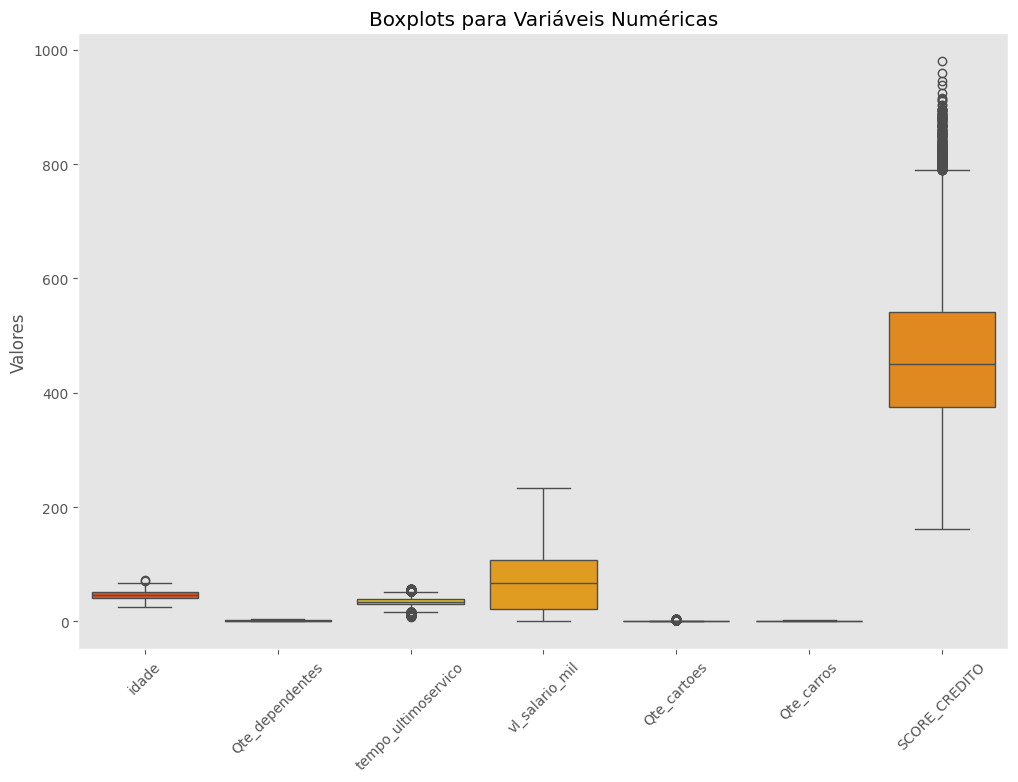

In [ ]:
# colunas numéricas relevantes
col_num = ['idade', 'Qte_dependentes', 'tempo_ultimoservico', 'vl_salario_mil', 'Qte_cartoes', 'Qte_carros', 'SCORE_CREDITO']
# 'vl_imovel_em_mil' foi retirado pela diferença entre eles

# configurações do gráfico
plt.figure(figsize=(12, 8))

# usando o seaborn para criar boxplots
sns.boxplot(data=scorecred[col_num], palette=cores_calor)

# ajustando os rótulos dos eixos
plt.xticks(rotation=45)
plt.ylabel('Valores')
plt.title('Boxplots para Variáveis Numéricas')
plt.grid(axis='y')  # adiciona grade ao eixo y
plt.show()

- **Idade**: no describe() retornou 46 anos mais ou menos e os quartis estão entre 41 e 52 anos. Tem poucos outliers.
- **Qtd de dependentes**: o que é normal é ter 1 dependente, mas variam principalmente entre 0 e 3 dependentes; como diferente, temos 5 dependentes (baseado também no describe())
- **Tempo no último serviço**: o que é normal é 34 meses, mas varia principalmente entre 30 e 39 meses; parece ter bastante outliers
- **Salário (mil)**: o que é normal é aproximadamente 50 mil, mas varia entre 20 e 80 mil; valores mais extremos com variabilidade?
- **Qtd de cartões de crédito**: o que é normal é 1 cartão, mas variam de 2 a 4 por pessoa; o valor máximo é 4.
- **Qtd de carros**: 0 carros é o normal, mas variam bastante entre 0 e 1; quando maior, vimos o 2.
- **Score de crédito**: valor normal é 450 e 500, mas variam entre 400 e 600; encontramos 850 como máx.

## **Insights**

- Salário e o Score tem maiores variabilidades
- Qtd de carros e de cartões não tem muita variabilidade
- Dependentes, idade e tempo no últ. serviço trazem uma distribuição mais ok.

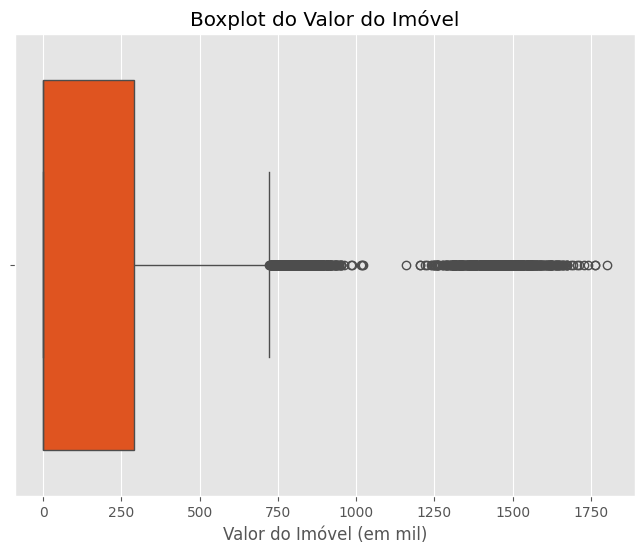

In [ ]:
# mediana do vl_imovel_em_mil
median_value = scorecred['vl_imovel_em_mil'].median() # no describe a mediana é 0, entao p entender

# figura e o boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=scorecred['vl_imovel_em_mil'])

# add título e rótulos aos eixos
plt.title('Boxplot do Valor do Imóvel')
plt.xlabel('Valor do Imóvel (em mil)')

# gráfico
plt.show()

In [ ]:
# tipo e describe de revisao
print(scorecred['vl_imovel_em_mil'].dtype)
print(scorecred['vl_imovel_em_mil'].describe())

int64
count    10127.000000
mean       208.999111
std        378.495229
min          0.000000
25%          0.000000
50%          0.000000
75%        289.000000
max       1800.000000
Name: vl_imovel_em_mil, dtype: float64


a mediana é realmente 0; mas essa variável tem variabilidade alta, indo de 0 até 1800, com std 378. vamos colocar 'NaN' e ver como funciona

In [ ]:
# colocando NaN nos valores '0'
scorecred['vl_imovel_em_mil'] = scorecred['vl_imovel_em_mil'].replace(0, np.nan)

In [ ]:
print(scorecred['vl_imovel_em_mil'].describe())

count    3569.000000
mean      593.032782
std       422.800512
min       150.000000
25%       269.000000
50%       451.000000
75%       784.000000
max      1800.000000
Name: vl_imovel_em_mil, dtype: float64


- count: 6558 eram 0 (diferença)
- media: a média subiu p? um valor ok, não?
- std: o desvio padrão aumentou - alta variabilidade (150 mil a 1.8mi)

Text(0.5, 0, 'Valor do Imóvel (em mil)')

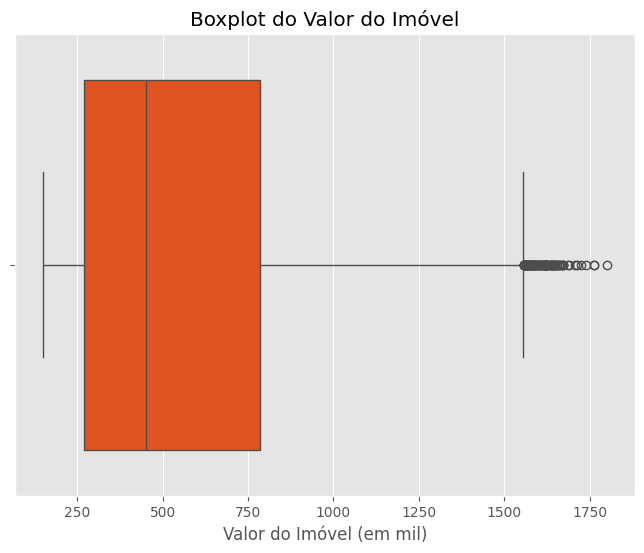

In [ ]:
# novo boxplot pós tratamento
plt.figure(figsize=(8, 6))
sns.boxplot(x=scorecred['vl_imovel_em_mil'])
plt.title('Boxplot do Valor do Imóvel')
plt.xlabel('Valor do Imóvel (em mil)')

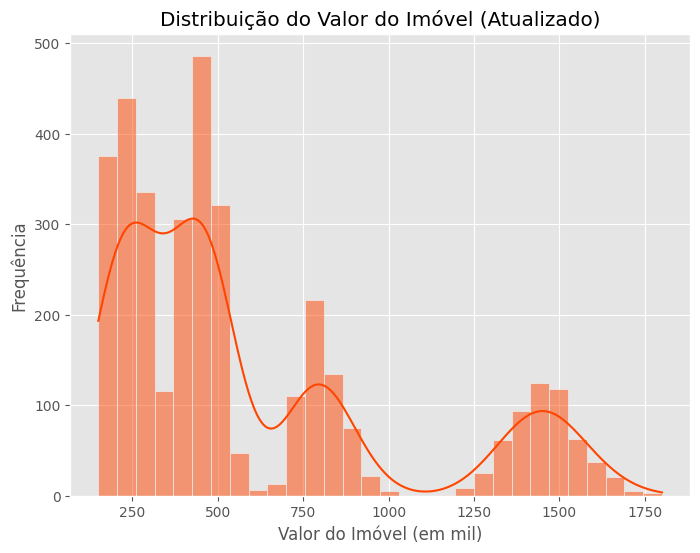

In [ ]:
# histograma
plt.figure(figsize=(8, 6))
sns.histplot(scorecred['vl_imovel_em_mil'], bins=30, kde=True)
plt.title('Distribuição do Valor do Imóvel (Atualizado)')
plt.xlabel('Valor do Imóvel (em mil)')
plt.ylabel('Frequência')
plt.show()

**Insights pós tratamento (de 0 para NaN)**:

- Vários picos?
- A maior concentração fica abaixo de R$800 mil
- Cauda à direita?
- Avaliar por localização?

In [ ]:
# separando por faixas de valor
bins = [0, 250, 500, 750, 1000, np.inf]
labels = ['Baixo', 'Moderado', 'Alto', 'Muito Alto', 'Extremo']

# criando a coluna de segmento de imóvel
scorecred['segmento_imovel'] = pd.cut(scorecred['vl_imovel_em_mil'], bins=bins, labels=labels, include_lowest=True) # include_lowest: o valor mais baixo é incluído no primeiro intervalo

# verificando a distribuição dos segmentos
print(scorecred['segmento_imovel'].value_counts())


segmento_imovel
Moderado      1482
Baixo          747
Extremo        565
Muito Alto     463
Alto           312
Name: count, dtype: int64


In [ ]:
# describe das faixas
for segmento in ['Moderado', 'Baixo', 'Extremo', 'Muito Alto', 'Alto']:
    print(f"Segmento: {segmento}")
    print(scorecred[scorecred['segmento_imovel'] == segmento]['vl_imovel_em_mil'].describe())
    print("\n")

Segmento: Moderado
count    1482.000000
mean      390.457490
std        79.679379
min       251.000000
25%       297.250000
50%       415.000000
75%       459.000000
max       500.000000
Name: vl_imovel_em_mil, dtype: float64


Segmento: Baixo
count    747.000000
mean     202.277108
std       29.181866
min      150.000000
25%      177.000000
50%      204.000000
75%      227.000000
max      250.000000
Name: vl_imovel_em_mil, dtype: float64


Segmento: Extremo
count     565.000000
mean     1453.097345
std       108.132927
min      1017.000000
25%      1382.000000
50%      1450.000000
75%      1520.000000
max      1800.000000
Name: vl_imovel_em_mil, dtype: float64


Segmento: Muito Alto
count    463.000000
mean     821.302376
std       51.734204
min      751.000000
25%      777.500000
50%      810.000000
75%      855.000000
max      987.000000
Name: vl_imovel_em_mil, dtype: float64


Segmento: Alto
count    312.000000
mean     594.589744
std       98.357107
min      501.000000
25%      51

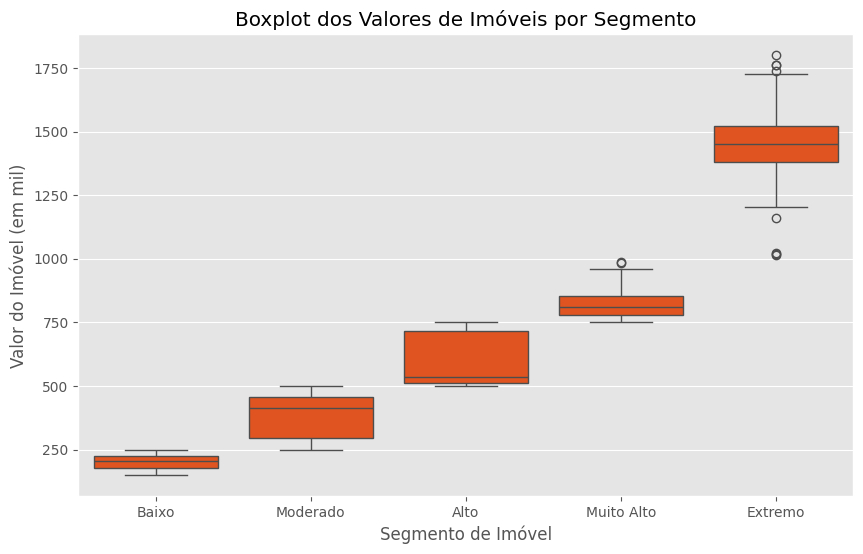

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='segmento_imovel', y='vl_imovel_em_mil', data=scorecred)
plt.title('Boxplot dos Valores de Imóveis por Segmento')
plt.xlabel('Segmento de Imóvel')
plt.ylabel('Valor do Imóvel (em mil)')
plt.show()

In [ ]:
# criar a variavel: valor do imóvel x salário
scorecred['vl_imovel_x_salario'] = scorecred['vl_imovel_em_mil'] / scorecred['vl_salario_mil']


# tratar possíveis inf e NaN pq ao rodar antes tinha dado erro.
scorecred['vl_imovel_x_salario'] = scorecred['vl_imovel_x_salario'].replace([np.inf, -np.inf], np.nan)
scorecred['vl_imovel_x_salario'] = scorecred['vl_imovel_x_salario'].fillna(0)

# normalização
scaler = StandardScaler() # para escalar features para ter média zero e std 1 para seguir
scorecred['vl_imovel_x_salario'] = scaler.fit_transform(scorecred[['vl_imovel_x_salario']].values.reshape(-1,1)) # fit calcula a média e o std e o transform aplica a transformação (subtrai a média e divide pelo std)

# conversão de variáveis categóricas em dummies
col_categoricas = ['segmento_imovel', 'sexo', 'estado_civil', 'escola', 'reg_moradia', 'trabalha', 'casa_propria']
col_categoricas_existentes = [col for col in col_categoricas if col in scorecred.columns]
scorecred = pd.get_dummies(scorecred, columns=col_categoricas_existentes)

# separa os conjuntos de treinamento e teste, mantendo NaN
X = scorecred.drop(columns=['SCORE_CREDITO', 'id'])
y = scorecred['SCORE_CREDITO']

# média das colunas nesses NaN
X_numeric = X.select_dtypes(include=[np.number])
X[X_numeric.columns] = X_numeric.apply(lambda x: x.fillna(x.mean()))

# separa os conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensões do conjunto de treino: {X_train.shape}, {y_train.shape}")
print(f"Dimensões do conjunto de teste: {X_test.shape}, {y_test.shape}")


Dimensões do conjunto de treino: (8101, 34), (8101,)
Dimensões do conjunto de teste: (2026, 34), (2026,)


- o conjunto de treino (X_train, y_train) 8101 amostras de dados (SCORE_CREDITO) e 30 variáveis explicativas no conjunto de treinamento

- o conjunto de teste (X_test, Y_test) tem 2026 amostras com as mesmas 30 variáveis explicativas no conjunto de treinamento

80% para treinamento e 20% para teste com o test_size = 0.2

In [ ]:
print(scorecred.columns)


Index(['id', 'idade', 'Qte_dependentes', 'tempo_ultimoservico',
       'vl_salario_mil', 'vl_imovel_em_mil', 'Qte_cartoes', 'Qte_carros',
       'SCORE_CREDITO', 'vl_imovel_x_salario', 'segmento_imovel_Baixo',
       'segmento_imovel_Moderado', 'segmento_imovel_Alto',
       'segmento_imovel_Muito Alto', 'segmento_imovel_Extremo', 'sexo_F',
       'sexo_M', 'estado_civil_casado', 'estado_civil_divorciado',
       'estado_civil_na', 'estado_civil_solteiro', 'escola_doutorado',
       'escola_ensino fundam', 'escola_ensino medio', 'escola_graduacao',
       'escola_mestrado', 'reg_moradia_1', 'reg_moradia_2', 'reg_moradia_3',
       'reg_moradia_4', 'reg_moradia_5', 'reg_moradia_6', 'trabalha_0',
       'trabalha_1', 'casa_propria_0', 'casa_propria_1'],
      dtype='object')


In [ ]:
# Regressão Linear para prever valores contínuos

# treinar o modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# fazer previsões
y_pred = modelo.predict(X_test)

# avaliar o modelo (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# R² Score - proporção da variabilidade que o modelo é capaz de explicar
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Mean Squared Error: 6531.9106060684235
R² Score: 0.6272399371568954


**Erro Quadrático Médio (MSE)**: 6531 indica a diferença MÉDIA ao quadrado entre os valores reais e os esperados. Qto mais baixo o valor, melhores as previsões.

**R² Score**: quer dizer que 62,72% da variação no Score_CREDITO é explicada pelo modelo. Se fosse 1, seria perfeito.

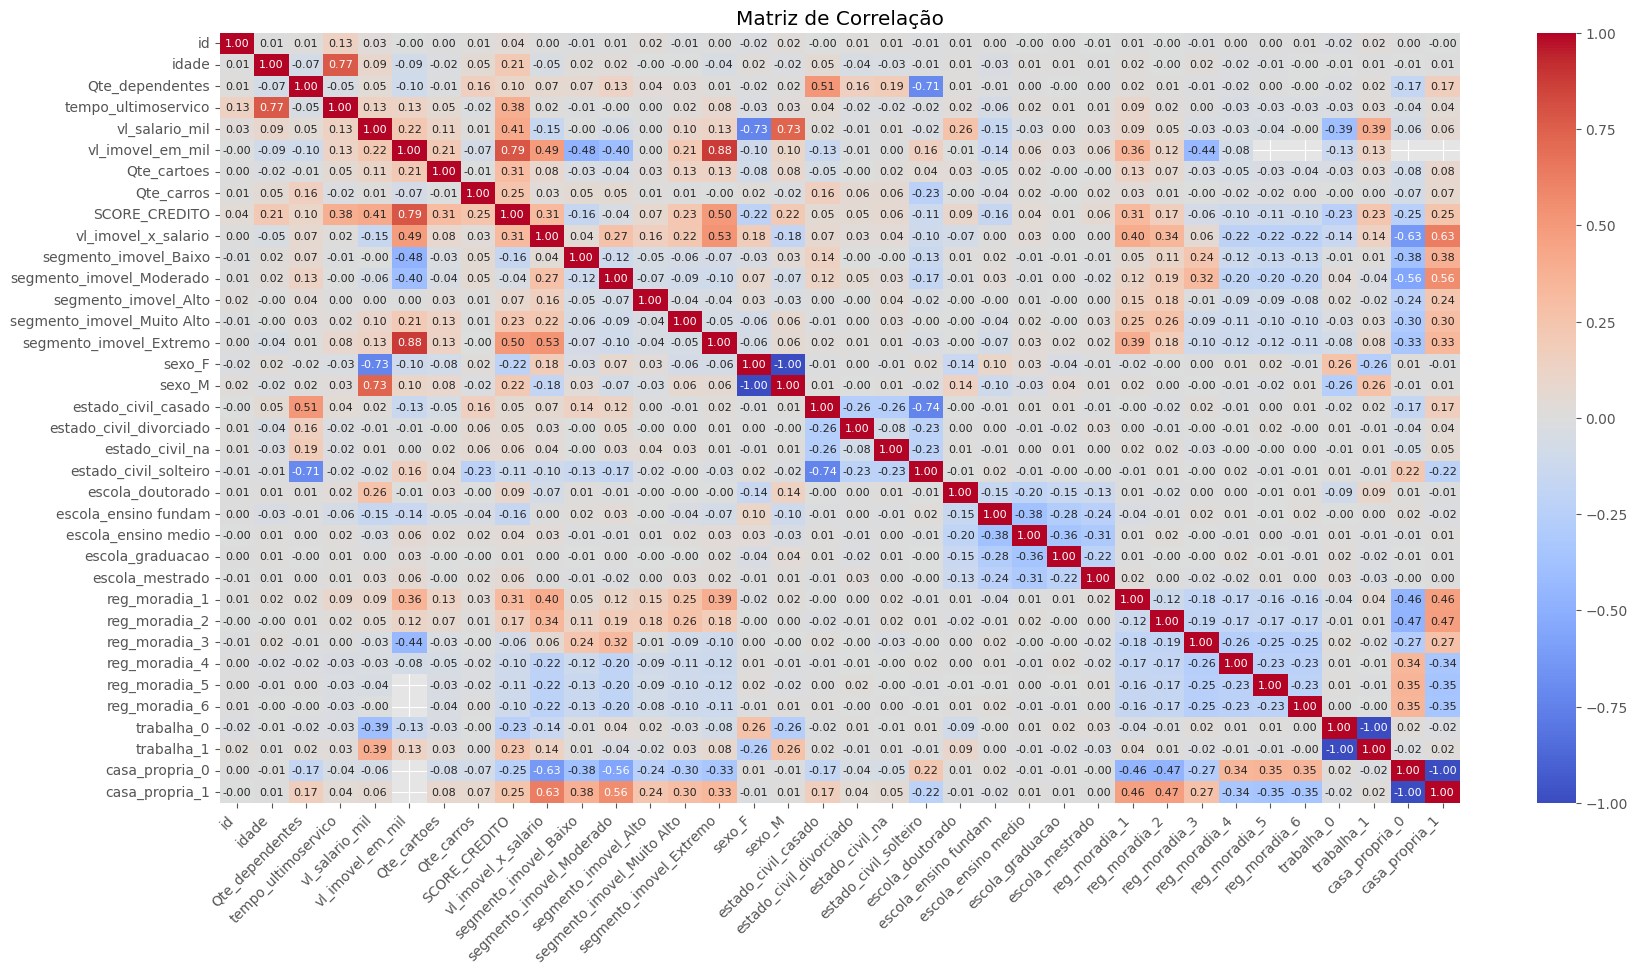

In [ ]:
# correlação
corr_matrix = scorecred.corr()
corr_matrix


plt.figure(figsize=(20, 10))  # Aumenta o tamanho da figura
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 8})  # Adiciona as anotações e define o formato
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo X para facilitar a leitura
plt.title('Matriz de Correlação')
plt.show()



## **Insights**

### **Correlação**

1. **maior salário** **tendem:** **a ter imóveis de maior valor**.

2. **idade x tempo_ultimoservico:** uma corr de 0.77 sugere que pessoas mais velhas tendem a ter mais tempo de serviço.

3. **estado_civil_casado x sexo_M:** corr de 0.51, sugerindo que uma parte significativa dos homens no dataset são casados.

4. **estado_civil_casado x sexo_F**: corr de -0.51, indicando que ser casado é negativamente correlacionado com ser mulher (provavelmente pq uma maior proporção de homens está casada neste dataset).

5. **vl_imovel_x_salario**: 0.23 sugere que aqueles que têm um imóvel proporcionalmente maior em relação ao salário = score de crédito um pouco >

6. **segmento_imovel_Baixo**: -0.16 levemente relacionados com um score de crédito menor

_______________________________________________________________________________

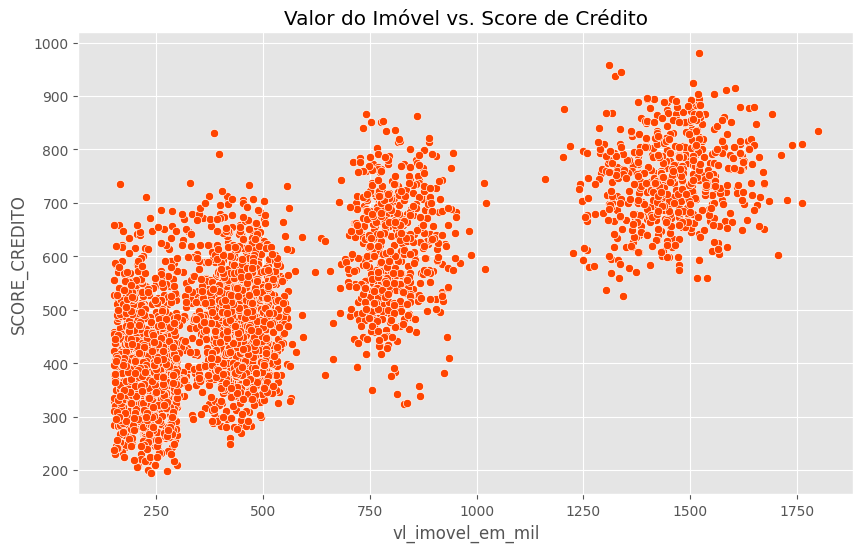

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vl_imovel_em_mil', y='SCORE_CREDITO', data=scorecred)
plt.title('Valor do Imóvel vs. Score de Crédito')
plt.show()

In [ ]:
# z-Score: calcular o Z-Score para cada variável numérica. se maior que 3 ou menor que -3 são considerados outliers.

z_score = np.abs(stats.zscore(scorecred[col_num])) # abs retorna o valor absoluto dos elementos do array fornecido. se z-score for '-2.5', o np.abs transforma em '2.5'
# e stats.zscore calcula os z-scores, que indicam qto um valor individual está em relação a média, medido em desvio padrão
outliers = np.where(z_score > 3)
print(outliers)


(array([   37,    65,    65,   126,   156,   224,   230,   262,   374,
         479,   527,   585,   609,   614,   707,   751,   843,   886,
         916,   958,  1020,  1047,  1096,  1228,  1278,  1298,  1431,
        1527,  1598,  1618,  1624,  1628,  1717,  1797,  1832,  1866,
        2042,  2065,  2093,  2153,  2233,  2237,  2251,  2251,  2424,
        2445,  2480,  2566,  2570,  2725,  2800,  2915,  2966,  2983,
        2985,  2997,  3011,  3114,  3116,  3186,  3193,  3243,  3282,
        3290,  3327,  3354,  3490,  3522,  3528,  3536,  3595,  3640,
        3640,  3705,  3740,  3769,  3777,  3903,  3948,  3960,  3961,
        3975,  3982,  4014,  4014,  4033,  4115,  4183,  4192,  4228,
        4254,  4376,  4456,  4569,  4593,  4612,  4807,  4890,  4913,
        4979,  4979,  4995,  5148,  5163,  5187,  5198,  5241,  5256,
        5266,  5311,  5481,  5598,  5703,  5768,  5872,  5983,  5997,
        6066,  6102,  6268,  6290,  6401,  6416,  6709,  6774,  6863,
        7064,  7075

In [ ]:
# Análise Comparativa - comparar outliers para ver se devemos excluir ou se fazem sentido.

outlier_scorecred = scorecred[(z_score > 3).any(axis=1)]
print(outlier_scorecred[['vl_imovel_em_mil', 'SCORE_CREDITO']])

       vl_imovel_em_mil  SCORE_CREDITO
37               1309.0         958.65
65               1325.0         938.00
126                 NaN         622.00
156               918.0         742.50
224               934.0         659.00
...                 ...            ...
9991              844.0         603.90
10001            1618.0         880.00
10004               NaN         879.00
10029             771.0         712.80
10086               NaN         500.40

[176 rows x 2 columns]


## **Insights**


	1. a primeira array traz os índices no DF, indicando onde estão os outliers. com isso, o primeiro, por exemplo, retorna que a linha 9 tem outlier
	2. a segunda array traz as colunas onde os valores são outliers.com isso, vimos que muitos outliers estão na coluna 4.
	3. linha 9 na coluna 4: 1580



__________

In [ ]:
variabilidade = scorecred.std() / scorecred.mean()
variabilidade.sort_values(ascending=False)

,0
vl_imovel_x_salario,4.751063e+17
segmento_imovel_Alto,5.609050e+00
segmento_imovel_Muito Alto,4.568876e+00
segmento_imovel_Extremo,4.114069e+00
segmento_imovel_Baixo,3.543746e+00
estado_civil_divorciado,3.541187e+00
estado_civil_na,3.538634e+00
escola_doutorado,3.513371e+00
trabalha_0,3.217788e+00
reg_moradia_1,2.917149e+00


## **Insights**

As variáveis com maior variabilidade são aquelas relacionadas a **estado civil**, **tipo de residência** e **nível de escolaridade**. Isso pode indicar uma grande diversidade nos dados para essas categorias. Podemos focar nas variáveis com maior coeficiente de variação, como "estado_civil_divorciado", "estado_civil_na", e "reg_moradia_2".

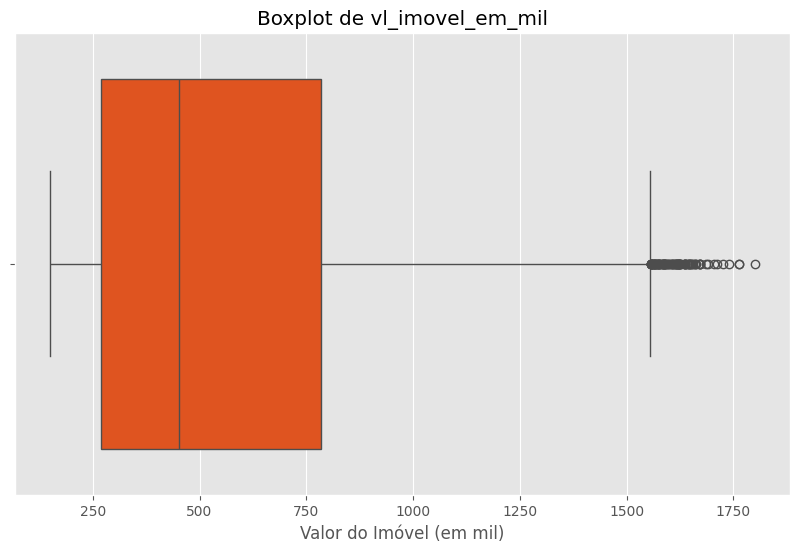

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=scorecred['vl_imovel_em_mil'])
plt.title('Boxplot de vl_imovel_em_mil')
plt.xlabel('Valor do Imóvel (em mil)')
plt.show()

### **Valores do Imóvel (em mil)**

A maioria dos valores se concentra abaixo de 750 mil, mas há diversos outliers que vão até 1750 mil. Esses outliers podem indicar valores muito alto que podem estar influenciando o modelo.

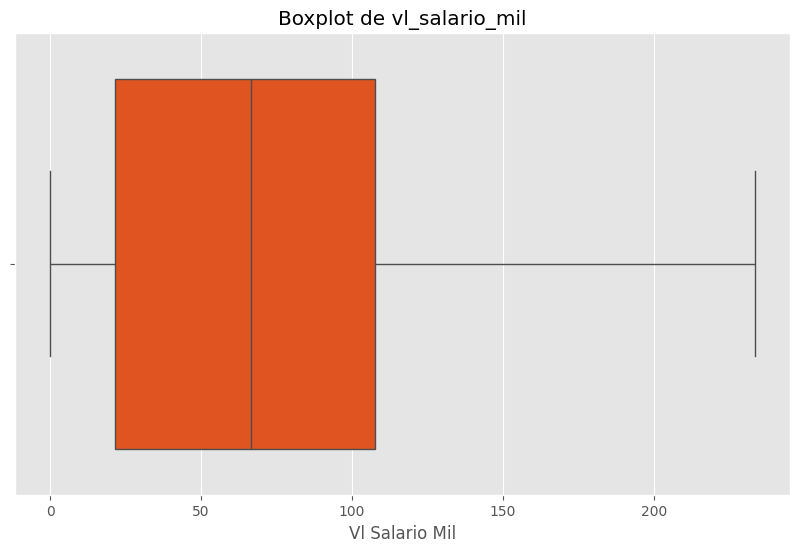

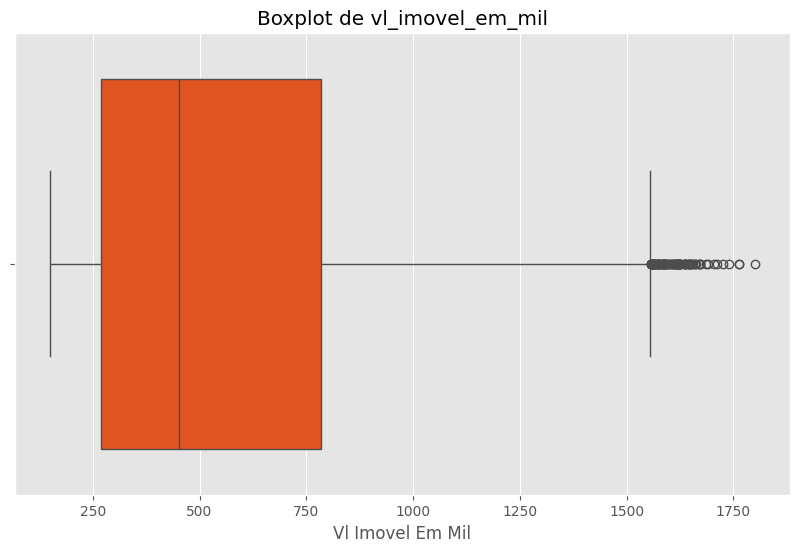

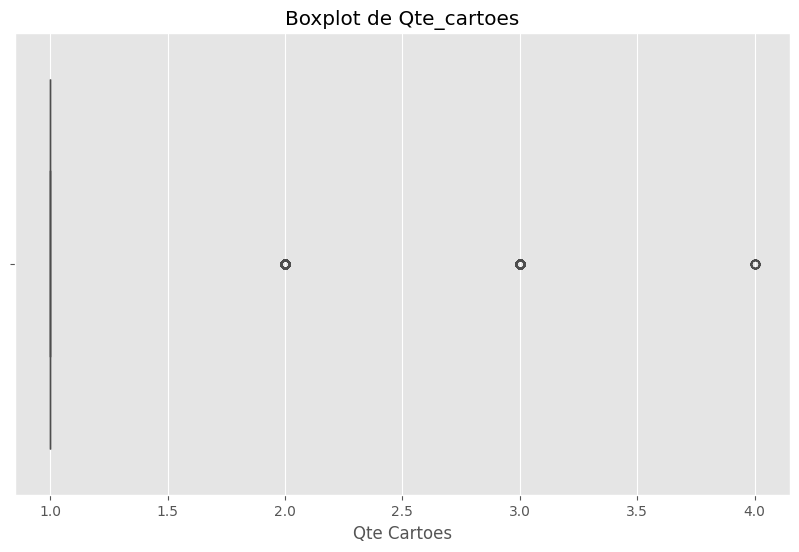

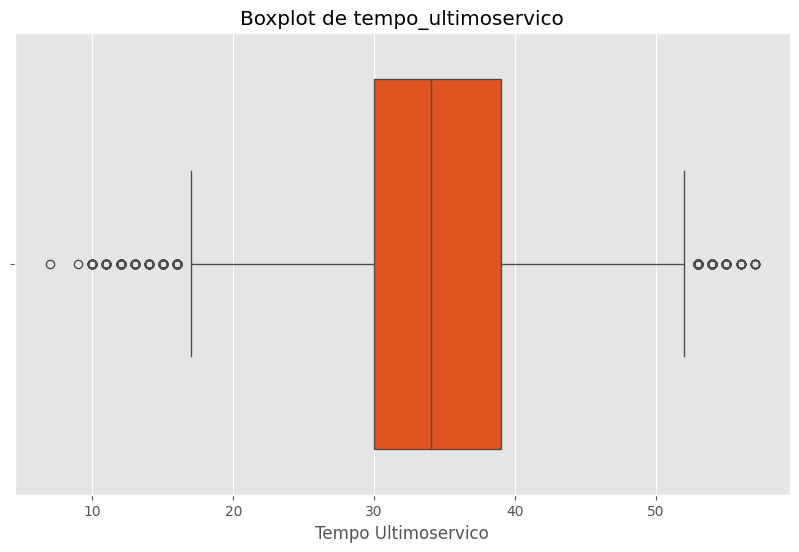

In [ ]:
variaveis_foco = ['vl_salario_mil', 'vl_imovel_em_mil', 'Qte_cartoes', 'tempo_ultimoservico']

for var in variaveis_foco:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=scorecred[var])
    plt.title(f'Boxplot de {var}')
    plt.xlabel(var.replace('_', ' ').title())

## **Insights**

In [ ]:
scorecred.columns

Index(['id', 'idade', 'Qte_dependentes', 'tempo_ultimoservico',
       'vl_salario_mil', 'vl_imovel_em_mil', 'Qte_cartoes', 'Qte_carros',
       'SCORE_CREDITO', 'vl_imovel_x_salario', 'segmento_imovel_Baixo',
       'segmento_imovel_Moderado', 'segmento_imovel_Alto',
       'segmento_imovel_Muito Alto', 'segmento_imovel_Extremo', 'sexo_F',
       'sexo_M', 'estado_civil_casado', 'estado_civil_divorciado',
       'estado_civil_na', 'estado_civil_solteiro', 'escola_doutorado',
       'escola_ensino fundam', 'escola_ensino medio', 'escola_graduacao',
       'escola_mestrado', 'reg_moradia_1', 'reg_moradia_2', 'reg_moradia_3',
       'reg_moradia_4', 'reg_moradia_5', 'reg_moradia_6', 'trabalha_0',
       'trabalha_1', 'casa_propria_0', 'casa_propria_1'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separar as variáveis independentes e a variável target
X = scorecred.drop(columns=['SCORE_CREDITO'])
y = scorecred['SCORE_CREDITO']

# Atualizar a lista de variáveis numéricas, já que as categóricas foram codificadas
numerical_features = ['idade', 'Qte_dependentes', 'tempo_ultimoservico', 'vl_salario_mil',
                     'vl_imovel_em_mil', 'Qte_cartoes', 'Qte_carros']

# Criar o pré-processador para apenas normalização de variáveis numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)  # Normalização das variáveis numéricas
    ],
    remainder='passthrough'  # Manter as colunas já codificadas
)

# Criar o pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Aplicar o pré-processamento
X_processed = pipeline.fit_transform(X)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Exibir as dimensões dos conjuntos de treino e teste
print(f"Dimensões do conjunto de treino: {X_train.shape}, {y_train.shape}")
print(f"Dimensões do conjunto de teste: {X_test.shape}, {y_test.shape}")

Dimensões do conjunto de treino: (8101, 35), (8101,)
Dimensões do conjunto de teste: (2026, 35), (2026,)


In [ ]:
from sklearn.model_selection import train_test_split

# Definindo as variáveis independentes (X) e dependentes (y)
X = scorecred.drop(columns=['SCORE_CREDITO', 'id'])  # Excluindo a coluna alvo e a coluna de ID
y = scorecred['SCORE_CREDITO']

# Dividindo em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Convertendo variáveis categóricas usando pd.get_dummies
X = pd.get_dummies(X, drop_first=True)  # drop_first=True para evitar a armadilha da variável dummy

In [ ]:
scorecred = pd.read_csv("Base_ScoreCredito_QuantumFinance.csv", delimiter=';')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Carregar os dados
scorecred = pd.read_csv("Base_ScoreCredito_QuantumFinance.csv")

# Convertendo colunas numéricas
scorecred['vl_salario_mil'] = pd.to_numeric(scorecred['vl_salario_mil'].str.replace(',', '.'), errors='coerce')
scorecred['SCORE_CREDITO'] = pd.to_numeric(scorecred['SCORE_CREDITO'], errors='coerce')

# Definindo as variáveis independentes (X) e dependentes (y)
X = scorecred.drop(columns=['SCORE_CREDITO', 'id'])  # Excluindo a coluna alvo e a coluna de ID
y = scorecred['SCORE_CREDITO']

# Convertendo variáveis categóricas para numéricas
X = pd.get_dummies(X, drop_first=True)

# Dividindo em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando e treinando o modelo
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Fazendo previsões
train_predictions = linear_model.predict(X_train)
test_predictions = linear_model.predict(X_test)

# Avaliando o modelo
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print(f"Treino RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Teste RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

ParserError: Error tokenizing data. C error: Expected 2 fields in line 3, saw 3


____________

regressao linear

In [ ]:
# Converter de volta para DataFrame para checar valores ausentes, se necessário
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

# Agora você pode usar isnull() para checar valores ausentes
print(X_train_df.isnull().sum())
print(X_test_df.isnull().sum())

# Se houver NaNs, podemos preencher com a média, por exemplo
X_train_df = X_train_df.fillna(X_train_df.mean())
X_test_df = X_test_df.fillna(X_test_df.mean())

0        0
1        0
2        0
3        0
4     5233
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
dtype: int64
0        0
1        0
2        0
3        0
4     1325
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
dtype: int64


<ipython-input-51-42cb0f6bf745>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_df = X_train_df.fillna(X_train_df.mean())
<ipython-input-51-42cb0f6bf745>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_df = X_test_df.fillna(X_test_df.mean())


In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Suponha que df é o seu DataFrame original com todas as colunas
# df = pd.read_csv('seu_arquivo.csv')  # Carregar seus dados
# Para fins de exemplo, vou criar um DataFrame simulado
data = {
    'idade': [25, 30, 35, 40, 45],
    'vl_salario_mil': [3, 4, 5, 6, 7],
    'segmento_imovel_Baixo': [1, 0, 0, 1, 0],
    'sexo_F': [1, 0, 0, 1, 0],
    'SCORE_CREDITO': [600, 700, 800, 900, 1000]
}
df = pd.DataFrame(data)

# Separar features e target
X = df.drop(columns=['SCORE_CREDITO'])
y = df['SCORE_CREDITO']

# Dividir em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir as colunas numéricas e categóricas
numeric_features = ['idade', 'vl_salario_mil']
categorical_features = ['segmento_imovel_Baixo', 'sexo_F']

# Definir o pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Criar o pipeline com o pré-processador e o modelo
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())])

# Ajustar o pipeline diretamente aos dados de treino
pipeline.fit(X_train, y_train)

# Fazer previsões diretamente no pipeline
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Exibir as previsões
print("Previsões do treino:", y_pred_train)
print("Previsões do teste:", y_pred_test)

Previsões do treino: [1000.  800.  600.  900.]
Previsões do teste: [700.]


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcular métricas para os dados de treino
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# Calcular métricas para os dados de teste
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Treino RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Teste RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

Treino RMSE: 5.684341886080802e-14, MAE: 2.842170943040401e-14, R²: 1.0
Teste RMSE: 0.0, MAE: 0.0, R²: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


## Resultados do Modelo

### Treino
- **RMSE**: 5.68×10<sup>-14</sup>  
  Isso é quase zero, o que sugere que o modelo se ajustou muito bem aos dados de treino.
  
- **MAE**: 2.84×10<sup>-14</sup>  
  Semelhante ao RMSE, o que indica um erro médio quase nulo.
  
- **R²**: 1.0  
  Um valor de R² igual a 1 significa que o modelo explica perfeitamente a variação nos dados de treino.

### Teste
- **RMSE**: 0.0  
  Isso significa que suas previsões para os dados de teste são idênticas aos valores reais, o que é suspeito.
  
- **MAE**: 0.0  
  Novamente, indica que o erro médio é zero nas previsões.
  
- **R²**: nan  
  Isso ocorre porque há apenas um valor de teste, tornando a métrica não definida.

In [ ]:
print("Dimensões de X_train_df:", X_train_df.shape)
print("Dimensões de y_train:", y_train.shape)

Dimensões de X_train_df: (8101, 35)
Dimensões de y_train: (4,)


In [ ]:
print("Número de amostras em X_train_df:", X_train_df.shape[0])
print("Número de amostras em y_train:", y_train.shape[0])

Número de amostras em X_train_df: 8101
Número de amostras em y_train: 4


In [ ]:
print(type(data))  # Isso deve retornar <class 'pandas.core.frame.DataFrame'>

<class 'dict'>


In [ ]:
import pandas as pd

# Se 'data' for um dicionário, converta-o em um DataFrame
data = pd.DataFrame(data)  # Assumindo que 'data' seja um dicionário válido

In [ ]:
from sklearn.model_selection import train_test_split

# Supondo que 'target_column' seja o nome correto da coluna de destino
X = data.drop(columns=['target_column'])  # Substitua pelo nome correto
y = data['target_column']  # Substitua pelo nome correto

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamanho de X_train:", X_train.shape)
print("Tamanho de y_train:", y_train.shape)

KeyError: "['target_column'] not found in axis"